Analysis of various approaches to NER. Only using pretrained models and not fine tunning them. Experimenting with following -
- OpenAI (Direct Call)
- OpenAI (through LlamaIndex)
- Spacy
- Hugging Face

In [3]:
#importing libraries
import openai
import os
from dotenv import load_dotenv, find_dotenv
import json
import spacy
import pandas as pd
import random
import ast
from llama_index.llms import OpenAI
from pydantic import BaseModel, ValidationError
from typing import List, Dict, Optional

import networkx as nx
import matplotlib.pyplot as plt

In [4]:
#loading keys
load_dotenv(find_dotenv())
openai.api_key = os.getenv("OPENAI_API_KEY")

In [5]:
#loading text data
input_text_chunk= open('./text/GDC-submission_G77-and-China/Page_1.txt', 'r', encoding="utf8")
input_text=input_text_chunk.read()

In [6]:
def graph_maker(data: dict, model_name: str):
    '''
    param: data is dictionary of entities and values generated form openai response.
    param: model_name is the text which tells about the model we used.
    output: network graph visualization.
    
    '''
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges
    for key, values in data.items():
        G.add_node(key)
        for value in values:
            G.add_edge(key, value)
            
    color=random.choices(['skyblue', 'salmon', 'orange', 'plum', 'lightgreen', 'lightyellow'])


    plt.figure(figsize=(10, 10))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color=color, font_size=8, font_color='black', arrowsize=5, connectionstyle='arc3,rad=0.1', edgecolors='k')
    plt.title(f'Visual for model: {model_name}')
    plt.show()

In [7]:
labels = [
    "PERSON",      # people, including fictional characters
    "ORG",         # organizations, companies, agencies, institutions
    "GPE",         # geopolitical entities like countries, cities, states
    "EVENTS",       # named sports, scientific milestones, historical events
    "DATE",        # mention of any article, treaty, law, acts, legislation, links.\n"
    "LAW",        # absolute or relative dates or periods
]

### Define Function to call OpenAI (Oneshot)

In [8]:
def system_message(labels):
    return f"""
You are an expert in Natural Language Processing. Your task is to identify common Named Entities (NER) in a given text.
The possible common Named Entities (NER) types are exclusively: ({", ".join(labels)})."""

def assisstant_message():
    return f"""
    Follow the Entity defination as below:
    1. PERSON: Short name or full name of a person from any geographic regions.
    2. ORG: Organizations, Companies, Agencies or Institutions.
    3. GPE: Geopolitical entities like name of countries, continents, cities, states, district.
    4. EVENTS: Scientific milestones, historical events, future events.
    5. DATE: Any format of dates. Dates can also be in natural language.
    6. LAW : Mention of any article, treaty, law, agenda, roadmap.
    --------
    Output Format:
    {{"PERSON": [list of entities present], "ORG": [list of entities present], "GPE": [list of entities present], "EVENTS": [list of entities present], "DATE": [list of entities present], "LAW": [list of entities present]}}
    If no entities are presented in any categories keep it an empty list. 
    Your output response MUST only contain a Dictionary object as specified in output format. If it is not in the format strip the string until you encounter a dictionary in the format specified.
    
    --------
    EXAMPLE:
    Text: 'To this end, internet restrictions should be considered not merely as technical measures affecting the logical or physical layers of the networks, but also as a tool used to impair the means of expression of individuals (see below, Avoid internet fragmentation). Therefore, internet shutdowns and content blocking may constitute violations of the principles contained in several international human rights instruments, in particular article 19 (right to freedom of expression, the scope of which is clarified by General Comment 34 of the Human Rights Committee) and article 21 (right of assembly) of the International Covenant on Civil and Political Rights (ICCPR). Regional conventions for the protection of human rights generally include similar provisions.
    This perspective is supported by the practice of several organs and international institutions, notably resolutions adopted by the Human Rights Council on 'The promotion, protection and fulfillment of human rights on the Internet' (A/HRC/32/L.20, June 27th, 2016). The Council condemns measures that seek to ' intentionally prevent or disrupt access to or dissemination of information online in violation of international human rights law, and calls upon all States to refrain from and cease such measures ', relying on a substantial number of secondary legislation not specifically related to the issue of Internet access. Several UN Special Rapporteurs have recognized the fundamental nature of the right of access to the Internet through the prism of freedom of expression or the right to peaceful assembly. However, this right of access to the internet should not be construed as a duty of States to provide access without any charge.'
    OUTPUT:
    {{"PERSON": [], "ORG": ["Human Rights Committee", "International Covenant on Civil and Political Rights (ICCPR)", "Human Rights Council", "UN", "Special Rapporteurs"], "GPE": ["States"],  "EVENTS": [], "DATE": ["June 27th, 2016"], "LAW": ["article 19 (right to freedom of expression", "article 21 (right of assembly)", "A/HRC/32/L.20", "international human rights law"] }}
    
 
    """


def user_message(text):
    return f"""
TASK:
    Text: {text}
"""


def run_openai_task(text: str, labels, model: str = 'gpt-3.5'):
    messages = [
          {"role": "system", "content": system_message(labels=labels)},
          {"role": "assistant", "content": assisstant_message()},
          {"role": "user", "content": user_message(text=text)}
      ]

    response = openai.chat.completions.create(
        model=model,
        temperature=0,
        messages=messages,
    )

    return response

### Define Function to call OpenAI (Oneshot) through LlamaIndex

In [9]:
def run_llama_ner_task(input_text:str, labels, model:str='gpt-3.5'):
    llm=OpenAI(temperature=0, model=model)
    response= llm.complete(
        f"""You are an expert in Natural Language Processing. Your task is to identify common Named Entities (NER) in a given text: {input_text}.
        The possible common Named Entities (NER) types are exclusively: ({", ".join(labels)}).
        --------
        Follow the Entity defination as below:
        1. PERSON: Short name or full name of a person from any geographic regions.
        2. ORG: Organizations, Companies, Agencies or Institutions.
        3. GPE: Geopolitical entities like name of countries, continents, cities, states, district.
        4. EVENTS: Scientific milestones, historical events, future events.
        5. DATE: Any format of dates. Dates can also be in natural language.
        6. LAW : Mention of any article, treaty, law, agenda, roadmap.
        --------
        Output Format:
        {{"PERSON": [list of entities present], "ORG": [list of entities present], "GPE": [list of entities present], "EVENTS": [list of entities present], "DATE": [list of entities present], "LAW": [list of entities present]}}
        If no entities are presented in any categories keep it an empty list. 
        Your output response MUST only contain a Dictionary object as specified in output format. If it is not in the format strip the string until you encounter a dictionary in the format specified.
        --------
        EXAMPLE:
        Text: 'To this end, internet restrictions should be considered not merely as technical measures affecting the logical or physical layers of the networks, but also as a tool used to impair the means of expression of individuals (see below, Avoid internet fragmentation). Therefore, internet shutdowns and content blocking may constitute violations of the principles contained in several international human rights instruments, in particular article 19 (right to freedom of expression, the scope of which is clarified by General Comment 34 of the Human Rights Committee) and article 21 (right of assembly) of the International Covenant on Civil and Political Rights (ICCPR). Regional conventions for the protection of human rights generally include similar provisions.
        This perspective is supported by the practice of several organs and international institutions, notably resolutions adopted by the Human Rights Council on 'The promotion, protection and fulfillment of human rights on the Internet' (A/HRC/32/L.20, June 27th, 2016). The Council condemns measures that seek to ' intentionally prevent or disrupt access to or dissemination of information online in violation of international human rights law, and calls upon all States to refrain from and cease such measures ', relying on a substantial number of secondary legislation not specifically related to the issue of Internet access. Several UN Special Rapporteurs have recognized the fundamental nature of the right of access to the Internet through the prism of freedom of expression or the right to peaceful assembly. However, this right of access to the internet should not be construed as a duty of States to provide access without any charge.'
        OUTPUT:
        {{"PERSON": [], "ORG": ["Human Rights Committee", "International Covenant on Civil and Political Rights (ICCPR)", "Human Rights Council", "UN", "Special Rapporteurs"], "GPE": ["States"],  "EVENTS": [], "DATE": ["June 27th, 2016"], "LAW": ["article 19 (right to freedom of expression", "article 21 (right of assembly)", "A/HRC/32/L.20", "international human rights law"] }}
        
        """
    )
    return response

# NER Implementation through Direct Call to OpenAI - OneShot Prompting
## Model -> "gpt-3.5-turbo"

In [10]:
NER1=run_openai_task(input_text, labels, "gpt-3.5-turbo")

In [11]:
data_1=eval(NER1.choices[0].message.content)

In [12]:
#check token usage
NER1.usage

CompletionUsage(completion_tokens=116, prompt_tokens=1043, total_tokens=1159)

# NER Implementation through Direct Call to OpenAI - OneShot Prompting
## Model -> "gpt-4"

In [13]:
NER2=run_openai_task(input_text, labels, "gpt-4")

In [14]:
data_2=eval(NER1.choices[0].message.content)

In [15]:
#check token usage
NER2.usage

CompletionUsage(completion_tokens=107, prompt_tokens=1043, total_tokens=1150)

# NER Implementation through OpenAI Via LlamaIndex- OneShot Prompting
## Model -> "gpt-3.5-turbo"

In [16]:
NER3=run_llama_ner_task(input_text, labels, "gpt-3.5-turbo")

In [17]:
data_3=eval(NER3.text)

In [18]:
#check token usage
NER3.raw['usage']

CompletionUsage(completion_tokens=98, prompt_tokens=1029, total_tokens=1127)

# NER Implementation through OpenAI Via LlamaIndex- OneShot Prompting
## Model -> "gpt-4"

In [19]:
NER4=run_llama_ner_task(input_text, labels, "gpt-4")

In [20]:
data_4=eval(NER4.text)

In [21]:
#check token usage
NER4.raw['usage']

CompletionUsage(completion_tokens=94, prompt_tokens=1029, total_tokens=1123)

# Using LlamaIndex Openai with oneshot - NER 
## Model -> "gpt-3.5-turbo"
## (Output Format as Tuple [('ENTITY', 'VALUE')])

I'm experimenting with another output format to see if the OpenAI gives me better result since it is now taking some time to format the output differently.

In [22]:
llm = OpenAI(temperature=0, model="gpt-3.5-turbo")
NER5 = llm.complete(
        f"""You are an expert in Natural Language Processing. Your task is to identify common Named Entities (NER) in a given text: {input_text}.
        The possible common Named Entities (NER) types are exclusively: ({", ".join(labels)}).
        --------
        Follow the Entity defination as below:
        1. PERSON: Short name or full name of a person from any geographic regions.
        2. ORG: Organizations, Companies, Agencies or Institutions.
        3. GPE: Geopolitical entities like name of countries, continents, cities, states, district.
        4. EVENTS: Scientific milestones, historical events, future events.
        5. DATE: Any format of dates. Dates can also be in natural language.
        6. LAW : Mention of any article, treaty, law, agenda, roadmap.
        --------
        Output the result as list of tuples with entity and entity values in the tuple:
        [('PERSON', 'entity present'), ('ORG', 'entity present'), ('GPE', 'entity present'), ('ENENTS', 'entity present'), ('DATE', 'entity present'), ('LAW', 'entity present')] 
        If no entities are presented in any categories keep it an empty list.
        Your output response MUST only contain a List object as specified in output format.
        
        EXAMPLE:
        Text: 'To this end, internet restrictions should be considered not merely as technical measures affecting the logical or physical layers of the networks, but also as a tool used to impair the means of expression of individuals (see below, Avoid internet fragmentation). Therefore, internet shutdowns and content blocking may constitute violations of the principles contained in several international human rights instruments, in particular article 19 (right to freedom of expression, the scope of which is clarified by General Comment 34 of the Human Rights Committee) and article 21 (right of assembly) of the International Covenant on Civil and Political Rights (ICCPR). Regional conventions for the protection of human rights generally include similar provisions.
        This perspective is supported by the practice of several organs and international institutions, notably resolutions adopted by the Human Rights Council on 'The promotion, protection and fulfillment of human rights on the Internet' (A/HRC/32/L.20, June 27th, 2016). The Council condemns measures that seek to ' intentionally prevent or disrupt access to or dissemination of information online in violation of international human rights law, and calls upon all States to refrain from and cease such measures ', relying on a substantial number of secondary legislation not specifically related to the issue of Internet access. Several UN Special Rapporteurs have recognized the fundamental nature of the right of access to the Internet through the prism of freedom of expression or the right to peaceful assembly. However, this right of access to the internet should not be construed as a duty of States to provide access without any charge.'
        [('PERSON', None), 
        ('ORG', 'Human Rights Committee'), 
        ('ORG', 'International Covenant on Civil and Political Rights (ICCPR)'), 
        ('ORG', 'Human Rights Council'), 
        ('ORG', 'UN'), 
        ('ORG', 'Special Rapporteurs'), 
        ('GPE', 'States'), 
        ('EVENTS', None), 
        ('Date', 'June 27th, 2016'),
        ('LAW', 'article 19 (right to freedom of expression'),
        ('LAW', 'article 21 (right of assembly)'),
        ('LAW', 'A/HRC/32/L.20'),
        ('LAW', 'international human rights law')]
        
        """
    )

In [23]:
NER5.text

"[('GPE', 'G77'), ('GPE', 'China'), ('ORG', 'Global Digital Compact'), ('GPE', 'States'), ('GPE', 'developing countries'), ('ORG', 'digital cooperation'), ('ORG', 'inclusive digital economy'), ('ORG', 'access to digital networks'), ('ORG', 'connectivity...), ('ORG', 'Internet Governance Forum'), ('ORG', 'Secretary-General Roadmap for Digital Cooperation'), ('ORG', 'Sustainable Development Goals (SDGs)'), ('ORG', 'International Telecommunication Union (ITU)'), ('ORG', 'STI Forum under the ECOSOC')]"

In [24]:
import ast
try:
    response_data = ast.literal_eval(NER5.text)
except (SyntaxError, ValueError) as e:
    print(f"Error evaluating the string: {e}")
    response_data = []

Error evaluating the string: invalid syntax (<unknown>, line 1)


In [26]:
import ast
try:
    response_data = ast.literal_eval(NER5.text)
except (SyntaxError, ValueError) as e:
    print(f"Error evaluating the string: {e}")
    response_data = []
    
from collections import defaultdict

ref_dic = defaultdict(list)

for key, value in response_data:
    if value is None:
        continue
        
    ref_dic[key].append(value)

Error evaluating the string: invalid syntax (<unknown>, line 1)


In [27]:
data_5=ref_dic

In [28]:
#check token usage
NER5.raw['usage']

CompletionUsage(completion_tokens=128, prompt_tokens=1050, total_tokens=1178)

# NER Using Spacy

In [29]:
NER_spacy = spacy.load("en_core_web_sm")
# a list of entites to exclude
exclude_entities = [ "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]

In [30]:
NER6=NER_spacy(input_text)

In [31]:
#changing output format to match for visualization
named_entities={}
for span in NER6.ents:
    if span.label_ not in exclude_entities:
        named_entities[span.label_]=[]
for span in NER6.ents:
    if span.label_ not in exclude_entities:
        named_entities[span.label_].append(span.text)

In [32]:
data_6=named_entities

# NER Using Hugging Face

In [33]:
from transformers import pipeline

# create pipeline for NER
ner = pipeline('ner', model ="dslim/bert-base-NER", aggregation_strategy = 'simple')

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
NER7=ner(input_text)

In [37]:
entities={}
for span in NER7:   
    entities[span['entity_group']]=[]
for span in NER7:
    entities[span['entity_group']].append(span['word'])

In [38]:
data_7=entities

## Visualization to Compare Results

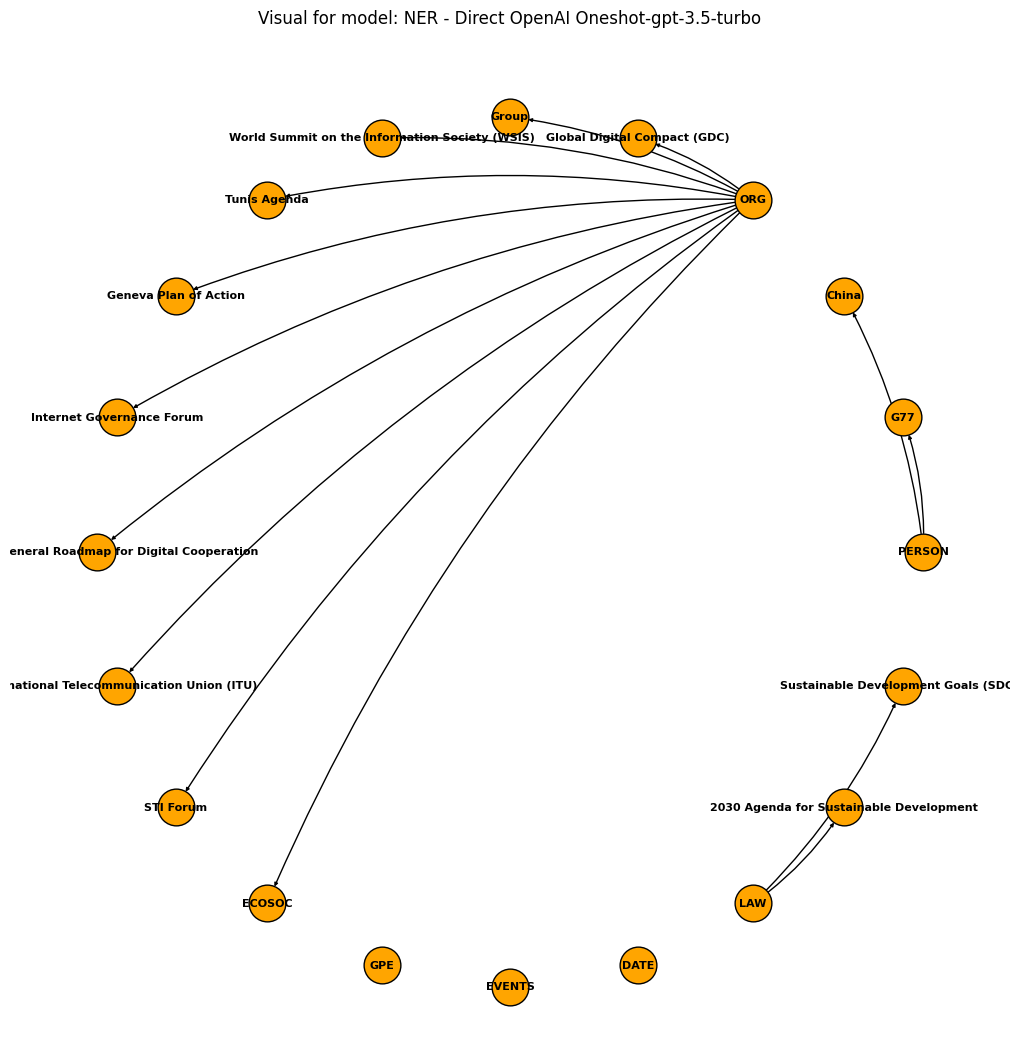

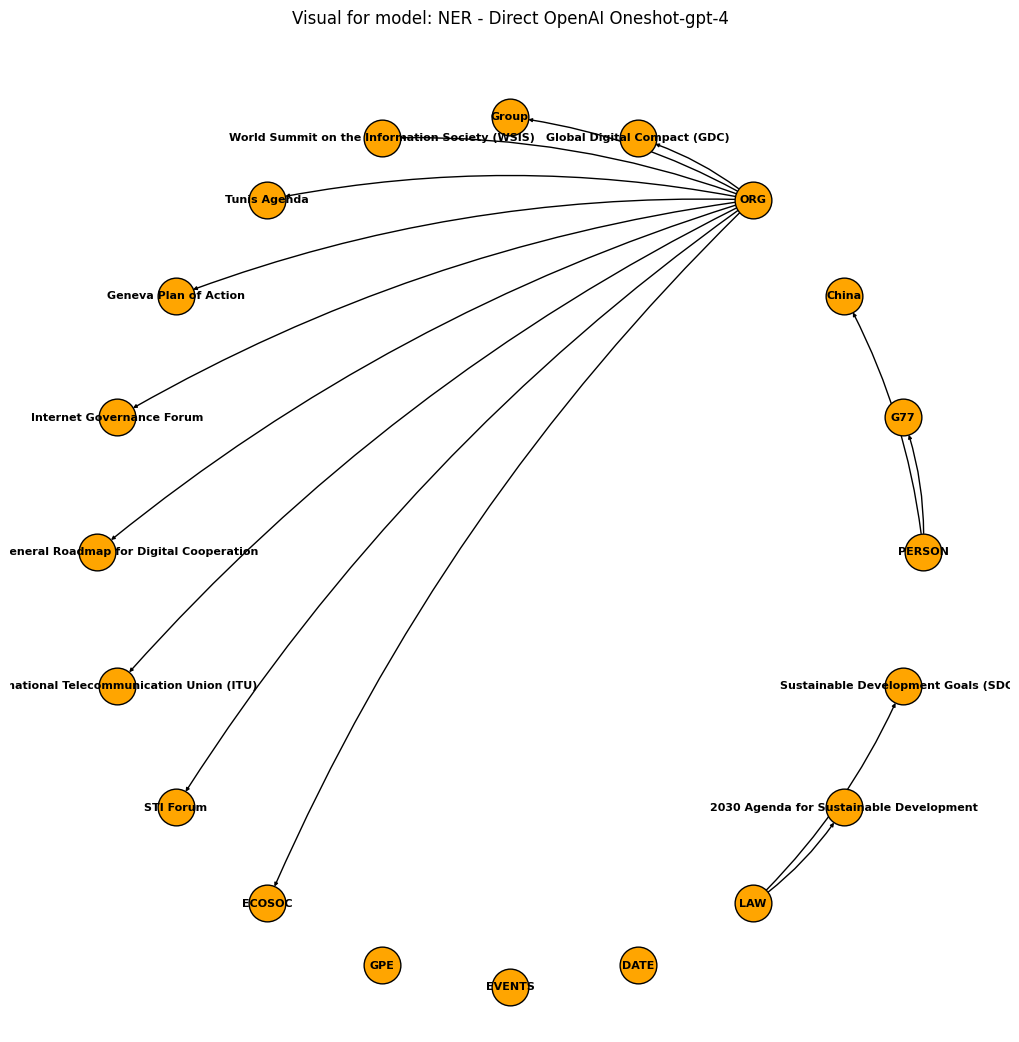

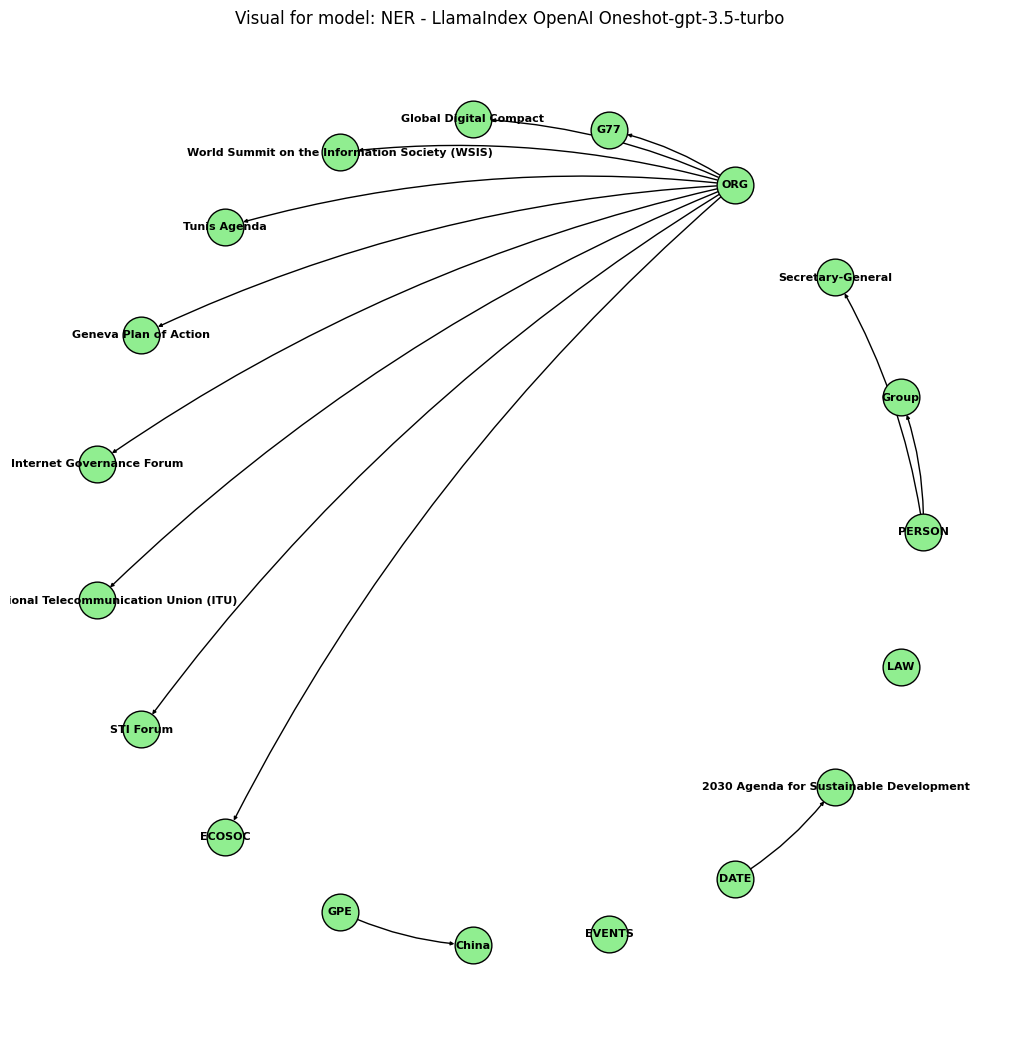

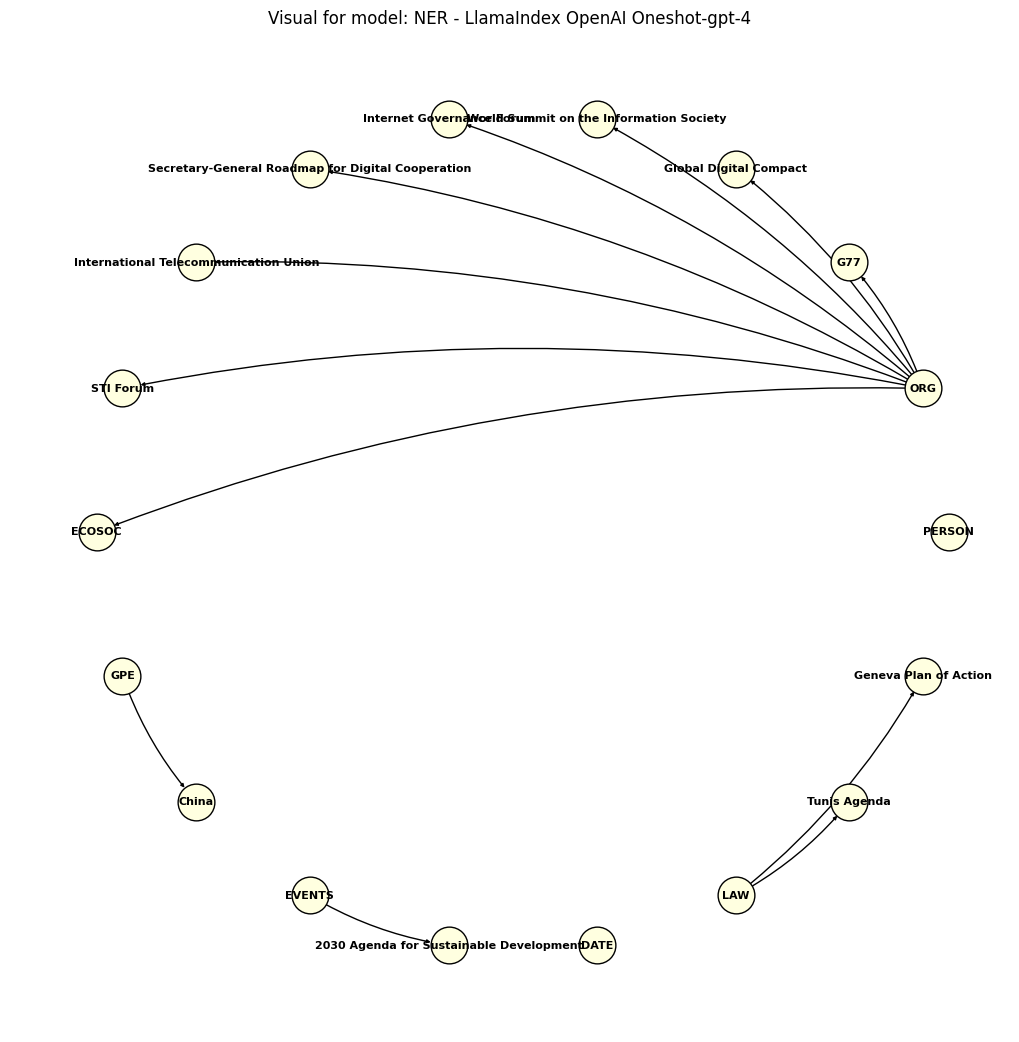

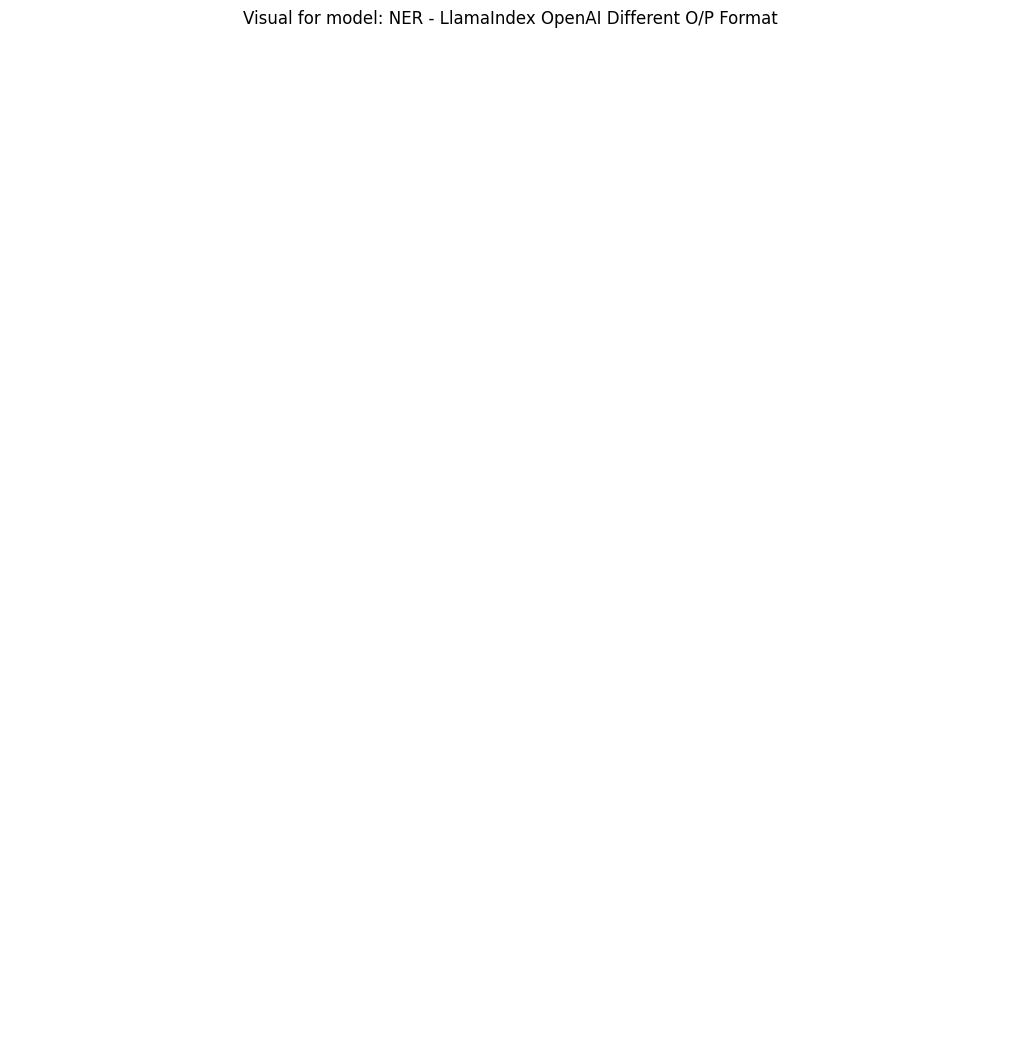

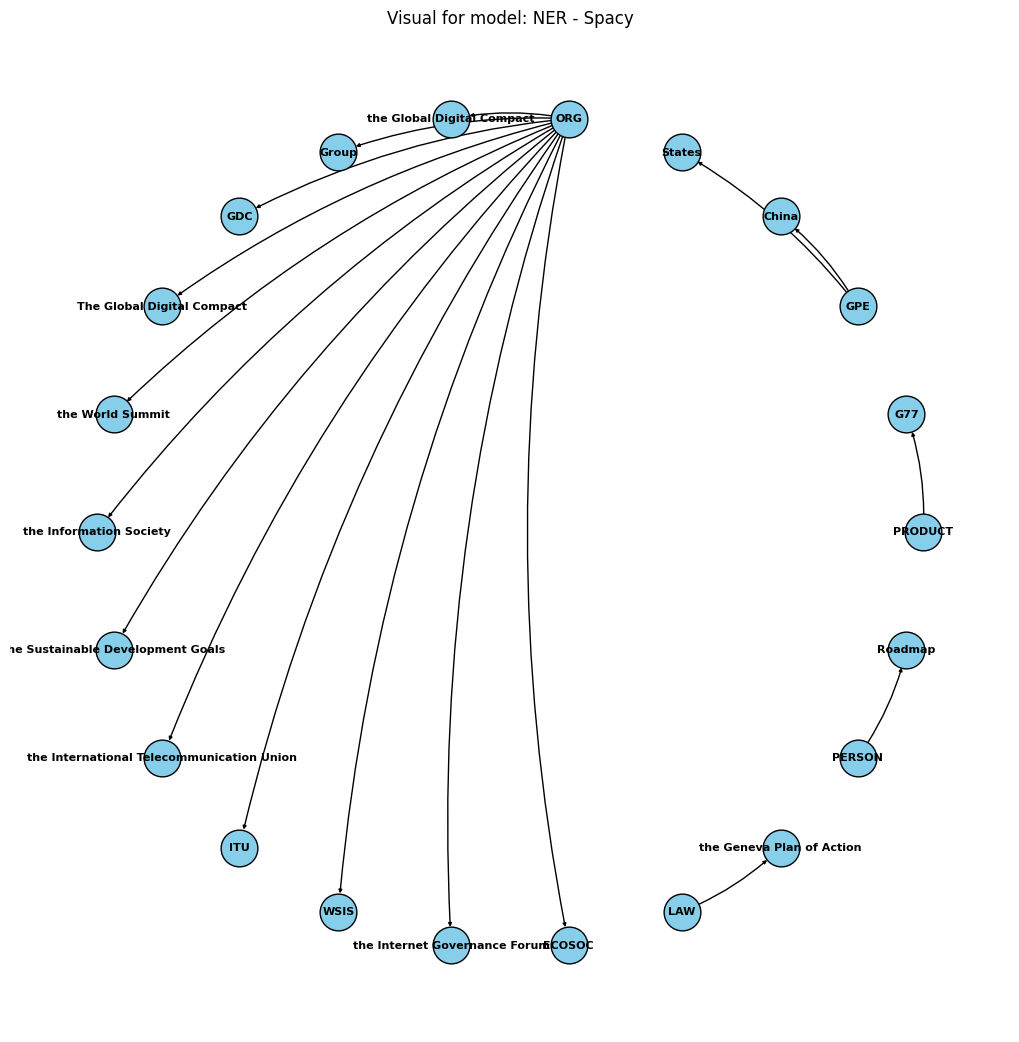

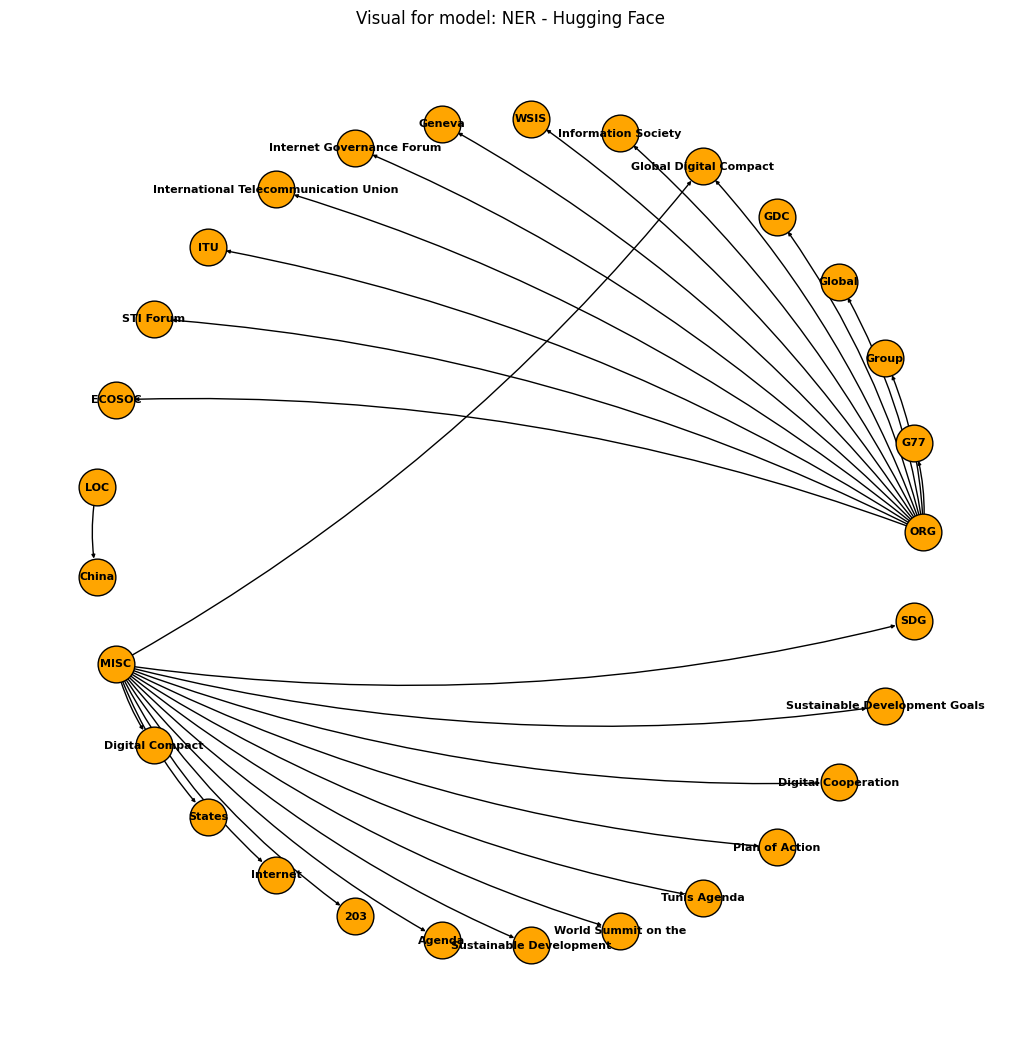

In [40]:
graph_maker(data_1, 'NER - Direct OpenAI Oneshot-gpt-3.5-turbo')
graph_maker(data_2, 'NER - Direct OpenAI Oneshot-gpt-4')
graph_maker(data_3, 'NER - LlamaIndex OpenAI Oneshot-gpt-3.5-turbo')
graph_maker(data_4, 'NER - LlamaIndex OpenAI Oneshot-gpt-4')
graph_maker(data_5, 'NER - LlamaIndex OpenAI Different O/P Format')
graph_maker(data_6, 'NER - Spacy')
graph_maker(data_7, 'NER - Hugging Face')

## Observation:

- If there is a change in the text of the prompt O/p changes.
- Both Direct Call to OpenAI and LlamaIndex yield more or less the same result.
I experimented with a couple of other documents gpt-4 is performing better in those documents.
- If the O/p format is changed to List of Tuples (with List of entity and value pairs the LLM gets confused for the O/p format).
However it works for the other text data that I experimented with. I'm sure the prompt cam be improved to catch this error. 
- The output format of Dictionary Object seems to be more robust with LLM.
- Pretrained Spacy could be a next best option after LLM.
- Hugging Face results are okay not that good.

In [42]:
#loading text data
input_text_chunk2= open('./text/GDC-submission_Global-Network-Initiative-GNI/Page_1.txt', 'r', encoding="utf8")
input_text2=input_text_chunk2.read()

In [45]:
NER=run_llama_ner_task(input_text2, labels, "gpt-4")

In [46]:
Result=eval(NER.text)

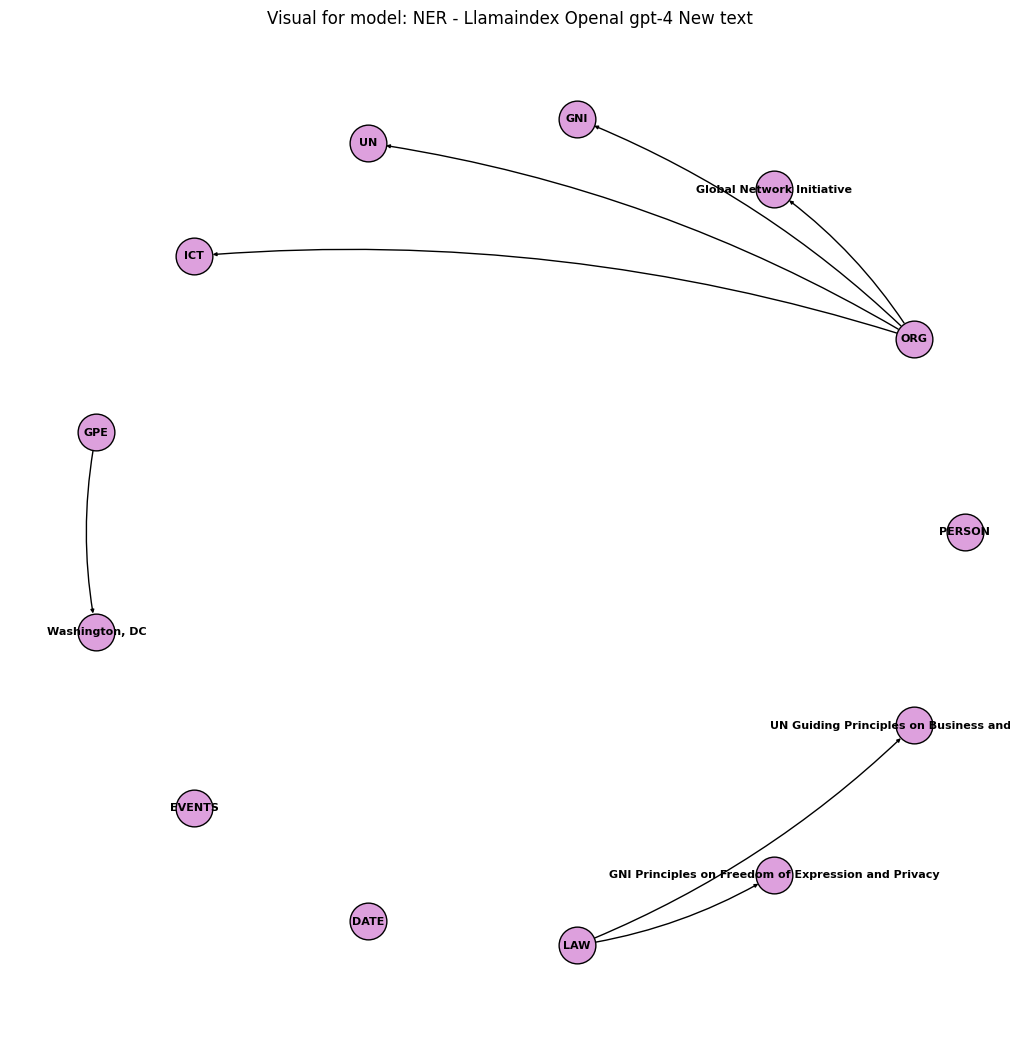

In [47]:
graph_maker(Result, 'NER - Llamaindex OpenaI gpt-4 New text')